In [281]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [282]:
df = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [284]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [285]:
print("train missing")
print(df.isna().sum())
print()
print("test missing")
print(df_test.isna().sum())

train missing
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

test missing
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Support imputation for:
- Age
- Fare
- Embarked

In [286]:
df['Survived'] = df['Survived'].map({0: False, 1: True})

df['Pclass'] = df['Pclass'].astype('category').cat.codes

df = df.rename(columns={'Sex': 'Male'})
df['Male'] = df['Male'].map({'male': True, 'female':False})

df.loc[df['Cabin'].notna(), 'HasCabin'] = True
df.loc[df['Cabin'].isna(), 'HasCabin'] = False
df['HasCabin'] = df['HasCabin'].astype('bool')

In [287]:
print(df['Embarked'].value_counts())
df['Embarked'] = df['Embarked'].fillna('S')

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


In [288]:
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
df['Title'].value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64

<Axes: xlabel='Title', ylabel='Survived'>

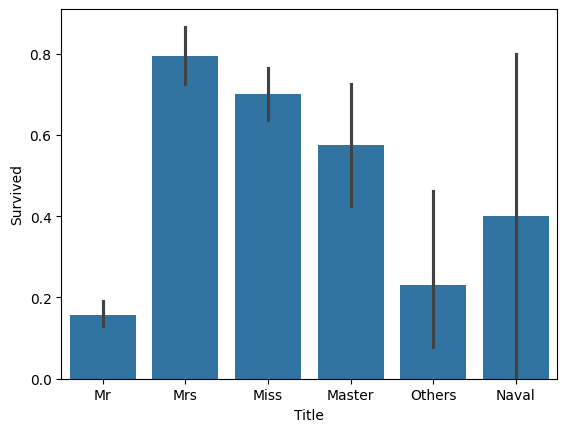

In [289]:
df['Title'] = df['Title'].replace(['Mlle', 'Ms', 'Jonkheer', 'Lady'], 'Miss')
df['Title'] = df['Title'].replace(['Mme', 'Dona', 'the Countess'], 'Mrs')
df['Title'] = df['Title'].replace(['Don', 'Sir'], 'Mr')
df['Title'] = df['Title'].replace(['Capt', 'Col', 'Major'], 'Naval')
df['Title'] = df['Title'].replace(['Dr', 'Rev'], 'Others')

sns.barplot(x='Title',y='Survived',data=df)

In [290]:
ages = df.groupby(['Title'])['Age'].transform('median')
df['Age'] = df['Age'].fillna(ages)

In [291]:
fares = df.groupby(['Pclass', 'Title'])['Fare'].transform('median')
df['Fare'] = df['Fare'].fillna(fares)

<Axes: xlabel='HasFamily', ylabel='Survived'>

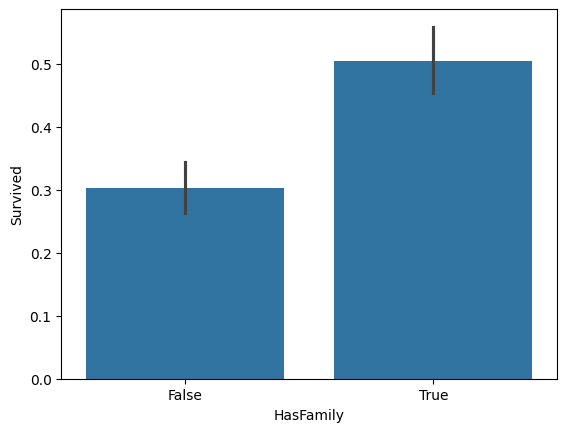

In [292]:
df['FamilySize'] = df['SibSp'] + df['Parch']
df['HasFamily'] = df['FamilySize'] > 0
sns.barplot(x='HasFamily', y='Survived',data=df)

<Axes: xlabel='BinnedFare', ylabel='Survived'>

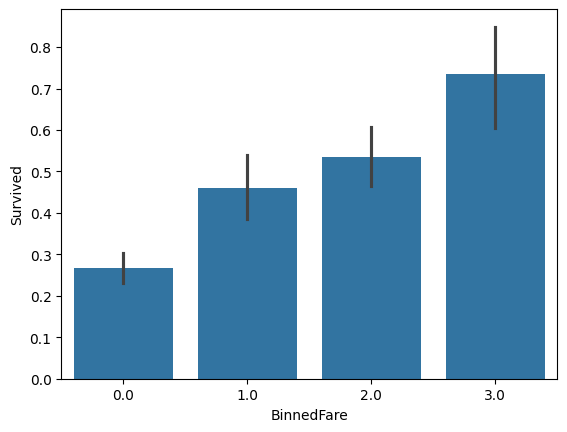

In [293]:
df.loc[df['Fare'] <= 17, 'BinnedFare'] = 0
df.loc[(df['Fare'] > 17) & (df['Fare'] <= 30), 'BinnedFare'] = 1
df.loc[(df['Fare'] > 30) & (df['Fare'] <= 100), 'BinnedFare'] = 2
df.loc[df['Fare'] >= 100, 'BinnedFare'] = 3
sns.barplot(x='BinnedFare',y='Survived',data=df)

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64


<Axes: xlabel='Parch', ylabel='Survived'>

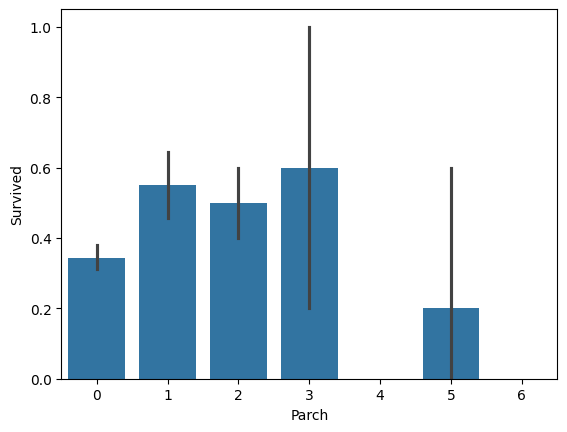

In [302]:
print(df['Parch'].value_counts())
sns.barplot(x='Parch',y='Survived',data=df)

In [294]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Male', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'HasCabin', 'Title',
       'FamilySize', 'HasFamily', 'BinnedFare'],
      dtype='object')

In [299]:
one_hot = ['Embarked', 'Title', 'Pclass', 'BinnedFare']
other = ['Male', 'HasCabin', 'Age', 'HasFamily']

df_one_hot = pd.get_dummies(df[one_hot], columns=one_hot)
X = df_one_hot.join(df[other + ['Survived']])
y = X['Survived']
X = X.drop(columns=['Survived'])

print(X.columns)

params = {
    'n_estimators': [200, 300, 400, 500, 600, 700, 800],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3,5,7],
    'subsample': [0.5, 0.7, 1]
}

gridcv = GridSearchCV(XGBClassifier(), cv=7, n_jobs=-1, param_grid=params)
gridcv.fit(X,y)

print(gridcv.best_score_)

Index(['Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Naval', 'Title_Others', 'Pclass_0',
       'Pclass_1', 'Pclass_2', 'BinnedFare_0.0', 'BinnedFare_1.0',
       'BinnedFare_2.0', 'BinnedFare_3.0', 'Male', 'HasCabin', 'Age',
       'HasFamily'],
      dtype='object')
0.8451472862767154
